In [ ]:
import os as os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
from sympy import *
from random import randrange

In [ ]:
import keras
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, Input, Dense, Dropout, Reshape, Flatten, Add, Lambda, \
    LSTM, GRU, Conv1D, Concatenate, BatchNormalization, TimeDistributed, RepeatVector, Activation
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

In [ ]:
#Generate solution for given initial conditions
def solver(nx=40,nt=99,x_len=1,t_len=0.2,plot=True ):
  
    #  Set parameters.
    nx = nx
    nt = nt
    x_length = x_len
    t_length = t_len
    g = 9.8
    
    #  Compute H and UH.
    
    h = np.zeros ( nx )
    uh = np.zeros ( nx )
    hm = np.zeros ( nx - 1 )
    uhm = np.zeros ( nx - 1 )
    x = np.zeros ( nx )
    t = np.zeros ( nt + 1 )
    h_array = np.zeros ( [ nx, nt + 1 ] )
    uh_array = np.zeros ( [ nx, nt + 1 ] )
    #
    #  Define the locations of the nodes and time steps and the spacing.
    #
    x = np.linspace ( 0, x_length, nx )
    t = np.linspace ( 0, t_length, nt + 1 )

    dx = x_length / float ( nx - 1 )
    dt = t_length / float ( nt )
    #  Apply the initial conditions.
    h = initial_conditions ( nx, x )
    uh=np.zeros(nx)
    
    #  Apply the boundary conditions.
    h[0] = h[nx-2]
    h[nx-1] = h[1]
    uh[0] = uh[nx-2]
    uh[nx-1] = uh[1]
    
   

    h_array[0:nx,0] = h[0:nx]
    uh_array[0:nx,0] = uh[0:nx]
    
    #  Take NT more time steps.
    for it in range ( 1, nt + 1 ):
    
    #  Take a half time step, estimating H and UH at the NX-1 spatial midpoints.
        hm[0:nx-1] = ( h[0:nx-1] + h[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( uh[1:nx] - uh[0:nx-1] ) / dx

        uhm[0:nx-1] = ( uh[0:nx-1] + uh[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( \
            uh[1:nx] ** 2    / h[1:nx]   + 0.5 * g * h[1:nx] ** 2 \
          - uh[0:nx-1] ** 2  / h[0:nx-1] - 0.5 * g * h[0:nx-1] ** 2 ) / dx
        
        #  Take a full time step, evaluating the derivative at the half time step,
        #  to estimate the solution at the NX-2 nodes.
      
        h[1:nx-1] = h[1:nx-1] \
          - dt * ( uhm[1:nx-1] - uhm[0:nx-2] ) / dx

        uh[1:nx-1] = uh[1:nx-1] \
          - dt * ( \
            uhm[1:nx-1] ** 2  / hm[1:nx-1] + 0.5 * g * hm[1:nx-1] ** 2 \
          - uhm[0:nx-2] ** 2  / hm[0:nx-2] - 0.5 * g * hm[0:nx-2] ** 2 ) / dx
        
        #  Update the boundary conditions.
        
        h[0] = h[nx-2]
        h[nx-1] = h[1]
        uh[0] = uh[nx-2]
        uh[nx-1] = uh[1]

        #  Copy data into the big arrays.

        h_array[0:nx,it] = h[0:nx]
        uh_array[0:nx,it] = uh[0:nx]

    x_min = min ( x )
    x_max = max ( x )

    h_min = 0.0
    h_max = np.amax ( h_array )

    uh_max = np.amax ( uh_array )
    uh_min = np.amin ( uh_array )
    
    if plot == True:
      #  Animation of H.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, h_array[:,it] )
              title_string = ( 'H(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'H(X,T)' )
              plt.show ( block = False )
          
      #  Animation of UH.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, uh_array[:,it] )
              title_string = ( 'UH(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'UH(X,T)' )
              plt.show ( block = False )
   
      print ( 'Normal end of execution.' )

    return h_array, uh_array, x, t


In [ ]:
#Random ICs
def initial_conditions ( nx, x ):

    H0=10
    x_max= np.amax(x)
    bumps=randrange(10)
    amp = np.random.rand(bumps)* (0.05*H0)
    pos = np.random.rand(bumps)*(0.75*x_max) + (0.125*x_max)
    Dissapation = 250

    Gaussian = H0*np.ones(nx)
    for i in range(len(amp)):
      if i%2 == 0:
        Gaussian += amp[i]*np.exp(-Dissapation*(x-pos[i])**2)

      elif i%2 != 0:
        Gaussian -= amp[i]*0.5*np.exp(-Dissapation*(x-pos[i])**2)
    
    h =  Gaussian
    return h

#Take only every n step in time and space
def prep_data(h,u,x,t,n):
    
    h= np.transpose(h[::n,::n])
    u= np.transpose(u[::n,::n])
    x=x[::n]
    t=t[::n]
    
    
    training_h= np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    labels_h=   np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    training_u= np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    labels_u=   np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    
    for i in range(0,len(h)-1):
        training_h[i] = h[i]
        labels_h[i] = h[i+1]
    
    for i in range(0,len(u)-1):
        training_u[i] = u[i]
        labels_u[i] = u[i+1]

    t=t[:-1]
        
    return training_h, labels_h, training_u, labels_u, x, t

#Merge several data sets with different ICs into one set of data for generality
def generate_data (rounds,nx,x_length,t_length):

  nt=nx-1


  h_array, uh_array, x, t   = solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)
  training_h, labels_h, training_u, labels_u, x, t = prep_data(h_array, uh_array, x, t,n=4)

  for i in range(rounds -1):

    h_array, uh_array, x, t=solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)

    training_hTemp, labels_hTemp, training_uTemp, labels_uTemp, x, t= prep_data(h_array, uh_array, x, t,n=4)

    training_h =np.concatenate((training_h,training_hTemp),axis=0)
    labels_h= np.concatenate((labels_h,labels_hTemp),axis=0)
    training_u=np.concatenate((training_u,training_uTemp),axis=0)
    labels_u=np.concatenate((labels_u,labels_uTemp),axis=0)
 
 

  return training_h,labels_h, training_u, labels_u ,x,t

def normalize(data):
  min = np.amin(data)
  max = np.amax(data)
  data = (data-min)/(max-min)
  return data 

def standardize(data):
  μ = np.mean(data)
  std = np.std(data)
  data = (data-μ)/std
  return data

In [ ]:
def main_data(rounds,nx,x_len):

  nx=nx
  nt= 2*nx -1
  x_len= x_len
  t_len= x_len/15

  training_h,labels_h, training_u, labels_u,x,t  = generate_data (rounds,nx,x_len,t_len)

  training_h=normalize(training_h)
  labels_h=normalize(labels_h)
  training_u=normalize(training_u)
  labels_u=normalize(labels_u)

  return training_h,labels_h, training_u, labels_u,x,t


In [ ]:
training_h,labels_h, training_u, labels_u,x,t= main_data(32,1024,1.5); 

In [ ]:
training_h.shape

(13260, 256)

In [ ]:
nodes= len(x)
cnn=Sequential()


cnn.add(Dense(nodes,input_shape=(nodes,),activation= 'tanh'))

cnn.add(Dense(nodes,activation= 'tanh'))
cnn.add(Dense(nodes,activation= 'tanh'))
cnn.add(Dense(nodes,activation= 'tanh'))
cnn.add(Dense(nodes,activation= 'tanh'))
cnn.add(Dense(nodes,activation= 'tanh'))



In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(optimizer=opt,
              loss="MSE", 
              metrics=['MeanSquaredError'])

cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
Total params: 394,752
Trainable params: 394,752
Non-trainable params: 0
__________________________________________________

In [ ]:
hist=cnn.fit(training_u,labels_u,batch_size=8,epochs=16,validation_split=0.25,verbose=1)

Epoch 1/16
1244/1244 [==============================] - 4s 3ms/step - loss: 1.8389e-04 - mean_squared_error: 1.8389e-04 - val_loss: 1.2944e-04 - val_mean_squared_error: 1.2944e-04
Epoch 2/16
1244/1244 [==============================] - 3s 3ms/step - loss: 1.3521e-04 - mean_squared_error: 1.3521e-04 - val_loss: 1.1793e-04 - val_mean_squared_error: 1.1793e-04
Epoch 3/16
1244/1244 [==============================] - 3s 3ms/step - loss: 1.2547e-04 - mean_squared_error: 1.2547e-04 - val_loss: 1.5905e-04 - val_mean_squared_error: 1.5905e-04
Epoch 4/16
1244/1244 [==============================] - 3s 3ms/step - loss: 1.1694e-04 - mean_squared_error: 1.1694e-04 - val_loss: 9.1156e-05 - val_mean_squared_error: 9.1156e-05
Epoch 5/16
1244/1244 [==============================] - 3s 3ms/step - loss: 1.0385e-04 - mean_squared_error: 1.0385e-04 - val_loss: 1.1025e-04 - val_mean_squared_error: 1.1025e-04
Epoch 6/16
1244/1244 [==============================] - 3s 3ms/step - loss: 1.0346e-04 - mean_square

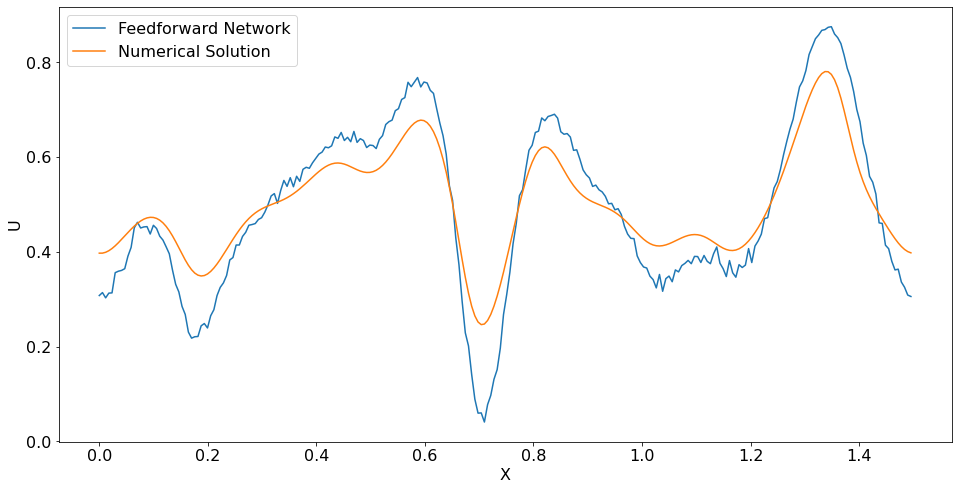

In [ ]:
i=randrange(10,1000)
IC= normalize(np.array([labels_u[i]]))
pred=cnn(IC)

fig, axes = plt.subplots(figsize=(16,8))
plt.plot(x,pred[0],label='Feedforward Network')
plt.plot(x,labels_u[i],label='Numerical Solution')
plt.xlabel("X")
plt.ylabel("U")

#plt.title("")
plt.legend()
plt.savefig('U Dense.pdf')  
plt.show()

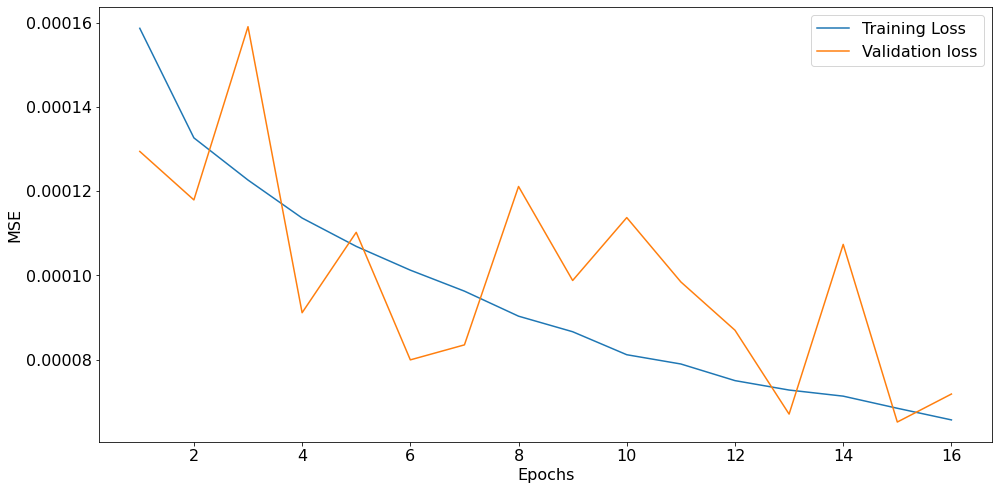

In [ ]:
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=np.linspace(1,16,16)
fig, axes = plt.subplots(figsize=(16,8))
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation loss')
#plt.title("Loss function per eoc")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
#plt.savefig('U loss Dense.pdf')  
plt.show()

In [ ]:
font = {'size'   : 16}
plt.rc('font', **font)

In [ ]:
IC= normalize(initial_conditions (256, x ))

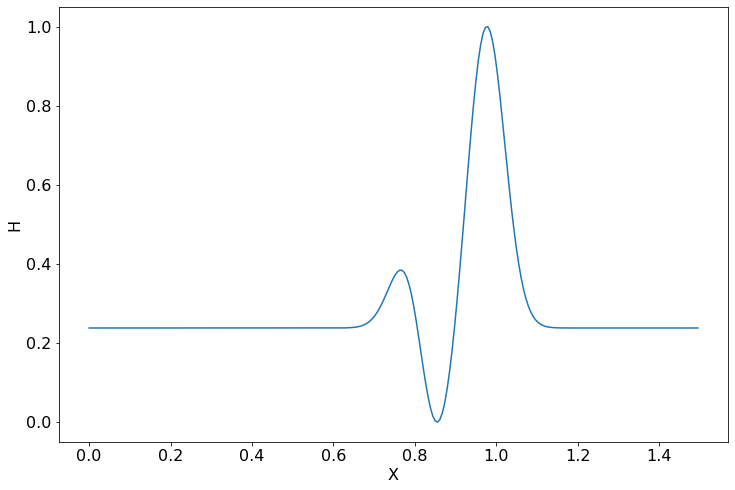

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
plt.plot(x,IC)
plt.xlabel("X")
plt.ylabel("H")
plt.savefig('IC1.pdf')
plt.show()

In [ ]:
x.shape

(256,)